## Features.py

In [1]:
import os

import cv2
import matplotlib.image as mpimg
import numpy as np
from joblib import Parallel, delayed
from skimage.feature import hog
from sklearn.utils import shuffle


def convert_color(img, cspace='YCrCb'):
    img = img.copy()
    if cspace != 'RGB':
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img = eval('cv2.cvtColor(img, cv2.COLOR_RGB2{})'.format(cspace))
    return img


def get_color_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1]) / 2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features


def get_bin_spatial_features(img, size=(32, 32)):
    feature_image = np.copy(img)
    features = cv2.resize(feature_image, size).ravel()
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to extract features from a list of images
# Have this function call get_bin_spatial_features() and get_color_hist_features()
def _extract_features(file, cspace='RGB', spatial=True, chist=True, hog=True,
                      spatial_size=(32, 32), hist_bins=32,
                      orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0
                      ):
    fvec = list()
    # Read in each one by one
    image = mpimg.imread(file)
    image = image * 255

    # apply color conversion if other than 'RGB'
    feature_image = convert_color(image, cspace)
    # print('image.shape', image.shape, 'maxval', image.max())
    # print('fimage.shape', feature_image.shape, 'maxval', feature_image.max())

    # Apply get_bin_spatial_features() to get spatial color features
    if spatial:
        spatial_features = get_bin_spatial_features(feature_image, size=spatial_size)
        fvec.append(spatial_features)

    # Apply get_color_hist_features() also with a color space option now
    if chist:
        _, _, _, _, hist_features = get_color_hist_features(feature_image, nbins=hist_bins)
        fvec.append(hist_features)

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog:

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        fvec.append(hog_features)

    fvec = np.concatenate(fvec)
    fvec = fvec.astype(np.float64)
    return fvec


def get_samples():
    #os.path.realpath('__file__')
    base = os.path.abspath('__file__')
    base = base.split('/bin/')[0]

    imgs = list()

    counter = 0
    y_labels = list()

    for subdir, dirs, files in os.walk(os.path.join(base, '/home/shubhi/Downloads/project/vehicles/vehicles')):
        for filename in files:

            filename = os.path.join(subdir, filename)

            if not filename.endswith('png'): continue

            # img = mpimg.imread(filename)
            imgs.append(filename)
            y_labels.append(1)
            counter += 1

    counter = 0
    for subdir, dirs, files in os.walk(os.path.join(base, '/home/shubhi/Downloads/project/non-vehicles/non-vehicles')):
        for filename in files:

            filename = os.path.join(subdir, filename)

            if not filename.endswith('png'): continue

            # img = mpimg.imread(filename)
            imgs.append(filename)
            y_labels.append(0)
            counter += 1

    return shuffle(imgs, np.array(y_labels))


def extract_features(imgs, cspace='RGB', spatial=True, chist=True, hog=True,
                     spatial_size=(32, 32), hist_bins=16, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     n_jobs=1
                     ):
    features = Parallel(n_jobs=n_jobs, verbose=10)(delayed(_extract_features)(file, cspace, spatial, chist, hog,
                                                                              spatial_size, hist_bins,
                                                                              orient, pix_per_cell, cell_per_block,
                                                                              hog_channel) for file in imgs)

    features = np.vstack(features)
    return features


if __name__ == '__main__':
    pass


## sliding_window.py

In [2]:
import cv2
import numpy as np

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes

    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    all_bboxes = list()
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((int(np.min(nonzerox)), int(np.min(nonzeroy))), (int(np.max(nonzerox)), int(np.max(nonzeroy))))
        # Draw the box on the image
        all_bboxes.append(bbox)

    for bbox in all_bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, scaler, cspace='RGB', spatial=True, chist=True, hog=True,
              spatial_size=(32, 32), hist_bins=16, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
              vis=True):

    bboxes = list()

    if vis:
        draw_img = np.copy(img)

    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hogs = [hog1, hog2, hog3]

    for xb in range(nxsteps):
        for yb in range(nysteps):
            test_features = list()
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            if spatial:
                spatial_features = get_bin_spatial_features(subimg, size=spatial_size)
                test_features.append(spatial_features)

            if chist:
                _, _, _, _, hist_features = get_color_hist_features(subimg, nbins=hist_bins)
                test_features.append(hist_features)

            if hog:
                # Extract HOG for this patch
                hog_features = list()
                if hog_channel == 'ALL':
                    for hogch in hogs:
                        hog_feat = hogch[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                        hog_features.append(hog_feat)
                    hog_features = np.hstack(hog_features)
                else:
                    hog_features = hogs[hog_channel][ypos:ypos + nblocks_per_window,
                                   xpos:xpos + nblocks_per_window].ravel()

                test_features.append(hog_features)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack(test_features).reshape(1, -1))
            test_prediction = clf.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)

                if vis:
                    cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                                  (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

                bbox = [(xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)]

                bboxes.append(bbox)

    if vis:
        return draw_img, bboxes
    else:
        return bboxes


## Tracker.py

In [3]:
from joblib import Parallel,delayed
import pickle
from skimage.filters import gaussian
from scipy.ndimage import label

# Search at at a single scale, keep hear to be able to parallelize the search
def _search_scale(img,scale, self):

    assert img.max() == 255

    feat_img = img.copy()
    bboxes = find_cars(feat_img, self.ystart, self.ystop, scale, **self.options, vis=False)

    return bboxes

# Used to treshold out detections which are too small, implements two different levels for close or far away detections
def remove_small_detections(labels, minsize_close=3000, minsize_far=2000):

    mapped  = labels[0]

    for i in range(1,labels[1]+1):
        nonzero = (mapped == i).nonzero()
        nonzeroy = np.max(np.array(nonzero[0]))

        size = np.sum(mapped==i)
        print(size)
        # Threshold out small detections which are close or far with two different thresholds
        if size < minsize_close and nonzeroy>450 or size< minsize_far and nonzeroy<=450:
            mapped[mapped==i] = 0

    return label(mapped)


class CarTracker(object):

    def __init__(self, model_file,
                 scales = [0.5, 1, 1.5, 2, 2.5, 3],
                 nsteps = 5,
                 threshold = 5,
                 vertical_roi=(400,656),
                 minsize_detection_close=np.inf,
                 minsize_detection_far = np.inf,
                 ):
        """
        Main class to perform detection on video
        :param train_clf_file: path to the output of the training script
        :param scales: scales to perform the search
        :param nsteps: keep the last nsteps and average across time, 0 to disable
        :param threshold: threshold confidence for the detection
        :param vertical_roi: (ystart,ystop) define a region of interest for the detection and the sliding window search
        :param minsize_detection_close= treshold for the size of far close detections (close objects appear bigger)
        :param minsize_detection_far = treshold for the size of far awy detections
        """
        self.model_file = model_file

        with open(model_file,'rb') as fh:
            self.options = pickle.load(fh)

        self.scales = scales
        self.nsteps = nsteps

        self.treshold = threshold

        self.ystart = vertical_roi[0]
        self.ystop = vertical_roi[1]

        #Keep a running list of last n heatmaps
        self._heatmaps = list()

        self.ncals = 0

        self.minsize_detection_close = minsize_detection_close
        self.minsize_detection_far = minsize_detection_far

    def process_image(self, img):

        assert img.max() == 255 and img.dtype == np.uint8 #assert that the image is correctly an rgb image

        self.ncals=+1

        current_heat = self.get_current_heatmap(img)

        heatmap = self._integrate_heatmap(current_heat)

        return self._treshold_and_label(img, heatmap)

    def get_current_heatmap(self, img):
        all_bboxes = list()

        # Search all scales in parallel
        tmp = Parallel(n_jobs=len(self.scales))(delayed(_search_scale)(img,scale,self) for scale in self.scales)

        [all_bboxes.extend(bboxes) for bboxes in tmp]

        # import ipdb; ipdb.set_trace()
        current_heat = np.zeros_like(img[:, :, 0]).astype(np.float)
        current_heat = add_heat(current_heat, all_bboxes)

        return current_heat

    # Integrate heatmap with past nsteps, smooth heatmap a little
    def _integrate_heatmap(self, current_heatmap):

        assert current_heatmap.ndim == 2

        if self._heatmaps and len(self._heatmaps) > self.nsteps:
            self._heatmaps.pop()

        self._heatmaps.append(current_heatmap)

        heatmap = np.dstack(self._heatmaps) if len(self._heatmaps) > 1 else current_heatmap

        print(heatmap.shape, heatmap.max())

        # Integrate Heatmap over time
        if heatmap.ndim == 3:
            heatmap = np.sum(heatmap, axis=-1)

            # Smooth a little the heatmaps
            heatmap = gaussian(heatmap, 4)

        return heatmap

    def _treshold_and_label(self, img, heatmap):

        heatmap[heatmap <= self.treshold] = 0

        heatmap = np.clip(heatmap, 0, 255)

        labels = label(heatmap)

        if self.minsize_detection_close:
            final_labels = remove_small_detections(labels, self.minsize_detection_close , self.minsize_detection_far)

        print('N cars detected ={}'.format(final_labels[1]))

        draw_img = draw_labeled_bboxes(np.copy(img), final_labels)

        return draw_img




## Exploration

In [4]:

import matplotlib.image as mpimg
import matplotlib.pylab as plt
import cv2
import numpy as np
%matplotlib inline


In [5]:
imgs, labels = get_samples()

In [11]:
imgs

['/home/shubhi/Downloads/project/non-vehicles/non-vehicles/Extras/extra4363.png',
 '/home/shubhi/Downloads/project/non-vehicles/non-vehicles/Extras/extra4703.png',
 '/home/shubhi/Downloads/project/vehicles/vehicles/KITTI_extracted/913.png',
 '/home/shubhi/Downloads/project/vehicles/vehicles/KITTI_extracted/3171.png',
 '/home/shubhi/Downloads/project/non-vehicles/non-vehicles/Extras/extra4003.png',
 '/home/shubhi/Downloads/project/vehicles/vehicles/GTI_MiddleClose/image0303.png',
 '/home/shubhi/Downloads/project/non-vehicles/non-vehicles/Extras/extra5493.png',
 '/home/shubhi/Downloads/project/vehicles/vehicles/KITTI_extracted/4516.png',
 '/home/shubhi/Downloads/project/non-vehicles/non-vehicles/Extras/extra2380.png',
 '/home/shubhi/Downloads/project/vehicles/vehicles/KITTI_extracted/3230.png',
 '/home/shubhi/Downloads/project/non-vehicles/non-vehicles/Extras/extra4490.png',
 '/home/shubhi/Downloads/project/non-vehicles/non-vehicles/GTI/image1014.png',
 '/home/shubhi/Downloads/project/no

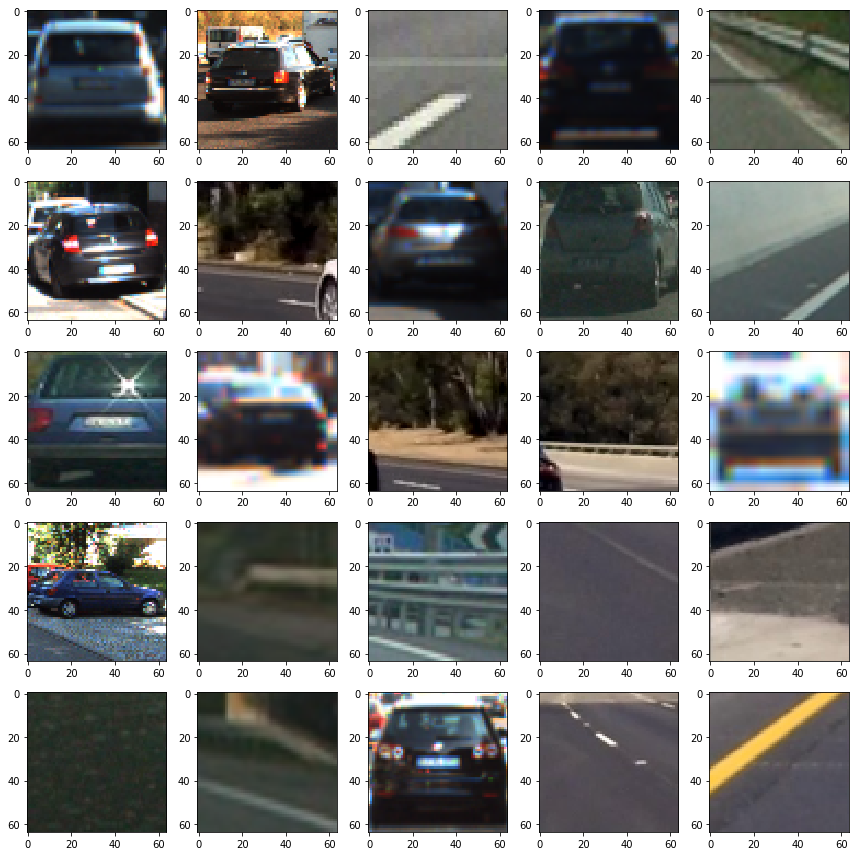

In [6]:
from PIL import Image
import skimage.io
from scipy.ndimage import zoom
from skimage.transform import resize

c=0
plt.figure(figsize=(12,12))
for img,label in list(zip(imgs,labels))[:25]:
    img = mpimg.imread(img)
    plt.subplot(5,5,c+1)
    plt.imshow(img)
    c+=1

plt.tight_layout()
plt.savefig('randoms.png')

## make frames

In [ ]:
import cv2
print(cv2.__version__)
vidcap = cv2.VideoCapture('project_video_small.mp4')
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frame%d.png" % count, image)     # save frame as JPEG file
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

# visualize HOG

/home/shubhi/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/home/shubhi/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


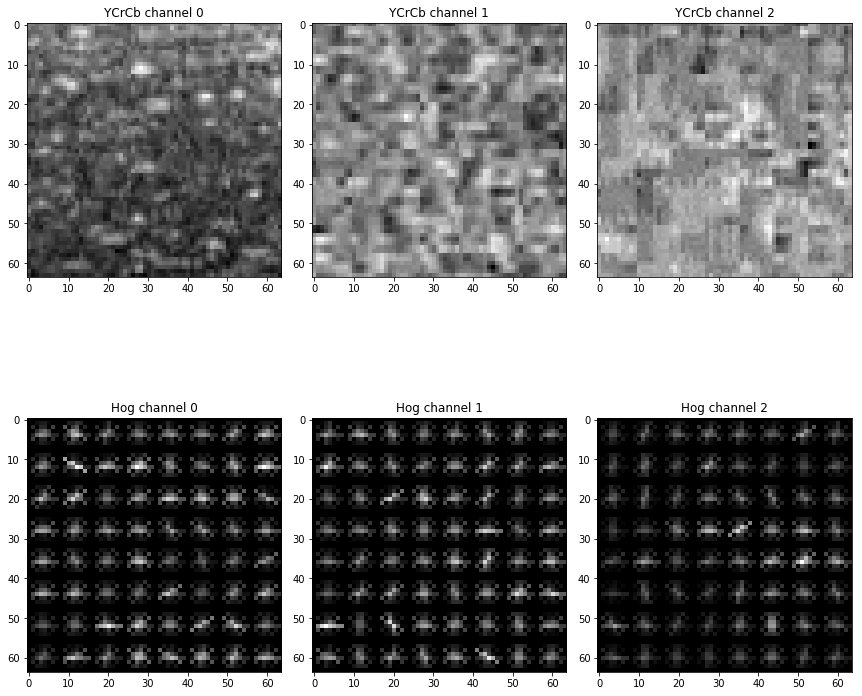

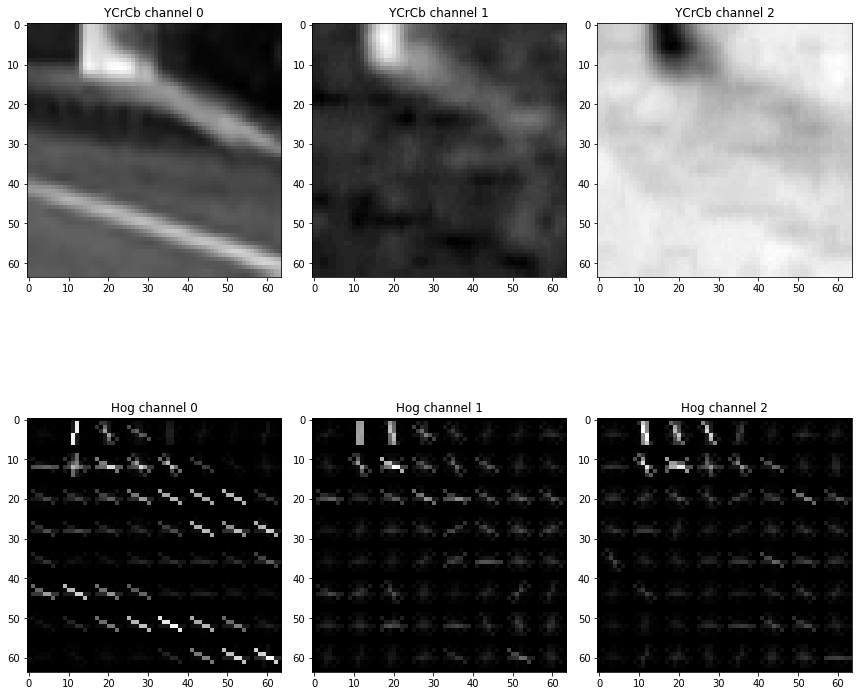

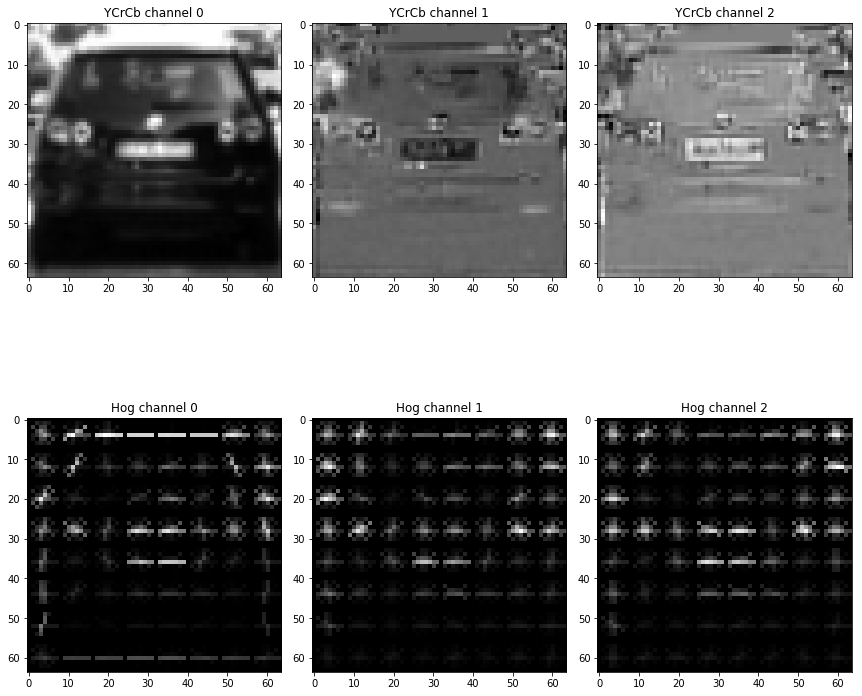

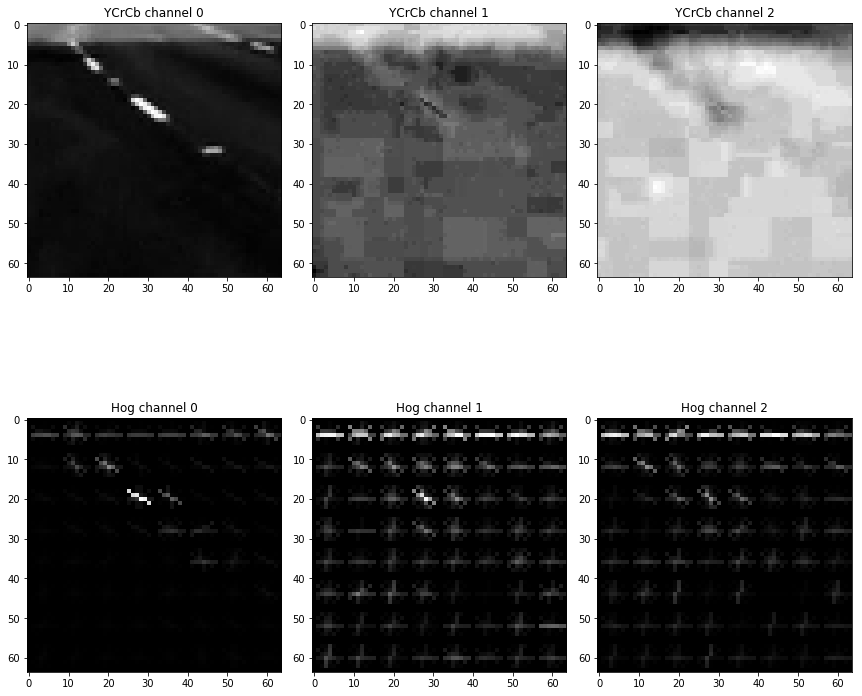

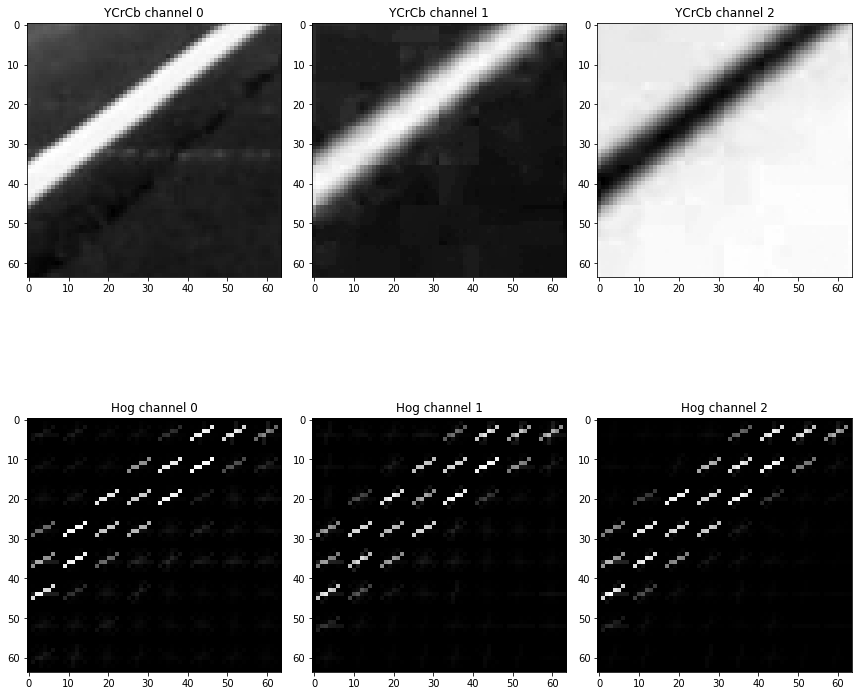

In [7]:
c=0

for img,label in list(zip(imgs,labels))[20:25]:
    c+=1
    plt.figure(figsize=(12,12))
    img = mpimg.imread(img)
    
    feat_img = convert_color(img)
    for ch in range(3):
        plt.subplot(2,3,1+ch)
        plt.imshow(feat_img[:,:,ch],cmap='gray')
        plt.title('YCrCb channel {}'.format(ch))
        f, hog_img = get_hog_features(feat_img[:,:,ch],9,8,2,vis=True)
        plt.subplot(2,3,4+ch)
        plt.title('Hog channel {}'.format(ch))
        plt.imshow(hog_img,cmap='gray')
        
        
    plt.tight_layout(pad=.8)
    plt.savefig('hogg_{}.png'.format(c))

In [26]:

tracker = CarTracker('/home/shubhi/Downloads/project/model.p',
                    nsteps=3,
                    threshold=4,
                    scales = [0.8, 1.5, 3, 4],
                    minsize_detection_close = 1000
                    )


count = 0
for i in range(106,106+20):

    img = mpimg.imread('/home/shubhi/Downloads/project/short_video_frames/frame%03d.png'%i)
    
    img*=255
    img = img.astype(np.uint8)
    assert img.max() == 255
    
    heat = tracker.get_current_heatmap(img)
    heat_integrated = tracker._integrate_heatmap(heat.copy())
    print(heat_integrated)
    res = tracker._treshold_and_label(img, heat_integrated)
    
    print(heat.max())
    fig = plt.figure(figsize=(14, 10))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
#     plt.suptitle('Timestep {}'.format(i))
    plt.subplot(221)
    plt.imshow(img)
    plt.title('Image timestep {}'.format(i))
    plt.subplot(222)
    plt.imshow(heat)
    plt.title('Heatmap')
    plt.subplot(223)
    
    plt.imshow(heat_integrated)
    plt.title('Heatmap Integrated & Smoothed')
    plt.subplot(224)
    plt.imshow(res)
    plt.title('Detections')
    plt.tight_layout()
    plt.savefig('pipeling_try_{}.png'.format(i-106))
    plt.show()

(720, 1280) 11.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: 'numpy.int64' object is not callable

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import time
from matplotlib import pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Define the paramters for the Features

options = dict(
    cspace='YCrCb',
    spatial=True,
    chist=True,
    hog=True,
    spatial_size=(32, 32),
    hist_bins=16,
    orient=9,
    pix_per_cell=8,
    cell_per_block=2,
    hog_channel='ALL',
)


# 1. Load the images
imgs, y = get_samples()

# 2. Extract features
X = extract_features(imgs, n_jobs=-1, **options)

scaler = StandardScaler()

# 3. Split / train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 4. Scale
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Feature vector length:', len(X_train[0]))

#  5. Use a linear SVC
svc = LinearSVC(loss='hinge',dual=True, penalty='l2')

# 6. Optimize hyperparameters using cross validation
svc = GridSearchCV(svc,param_grid={'C': [100],
                                   'intercept_scaling': [100],
                                   # 'class_weight': [{0: 1, 1:2 }, {0:1, 1: 3}]
                                   }, n_jobs=None, verbose=10)

t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample

t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
y_pred = svc.predict(X_test)
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm,['non-cars','cars'])

plt.savefig('confusion_matrix_try.png')
print(svc.best_estimator_)

# Final: Export trained model to file
import pickle

options['scaler'] = scaler
options['clf'] = svc.best_estimator_

with open('/home/shubhi/Downloads/project/model.p', 'wb') as fh:
    pickle.dump(options,fh)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1704s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0495s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 476 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 892 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1132 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 1372 tasks      | elapsed:    8.5s
[Parallel(n

Feature vector length: 8412


/home/shubhi/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=100, intercept_scaling=100 ....................................
[CV]  C=100, intercept_scaling=100, score=0.9911317567567568, total=  16.0s
[CV] C=100, intercept_scaling=100 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.2s remaining:    0.0s


[CV]  C=100, intercept_scaling=100, score=0.9900760135135135, total=   9.5s
[CV] C=100, intercept_scaling=100 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.8s remaining:    0.0s


[CV]  C=100, intercept_scaling=100, score=0.9869087837837838, total=  10.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.5s finished


55.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9885
My SVC predicts:  [0 1 0 0 1 1 1 1 0 1]
For these 10 labels:  [0 1 0 0 1 1 1 1 0 1]
0.0302 Seconds to predict 10 labels with SVC
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1813
           1       0.99      0.99      0.99      1739

   micro avg       0.99      0.99      0.99      3552
   macro avg       0.99      0.99      0.99      3552
weighted avg       0.99      0.99      0.99      3552

Confusion matrix, without normalization
[[1791   22]
 [  19 1720]]
LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=100, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [11]:
import pickle
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
import numpy as np
import sys

white_output = '/home/shubhi/Downloads/project/output1.mp4'
input = '/home/shubhi/Downloads/project/project_video.mp4'

print('Input file ', input)
print('Output file', white_output)

clip1 = VideoFileClip(input)



# tracker = CarTracker('model.p',
#                      nsteps=3,
#                      threshold=4,
#                      scales=[0.8, 1, 1.5, 2],
#                      minsize_detection=800
#                      )

tracker = CarTracker('/home/shubhi/Downloads/project/model.p',
                     nsteps=3,
                     threshold=6,
                     scales=[0.8,1, 1.5, 3, 6],
                     minsize_detection_close=np.inf,
                     minsize_detection_far=500
                     )


#clip1.write_images_sequence('short_video_frames/frame%03d.png')
white_clip = clip1.fl_image(tracker.process_image)  # NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

ModuleNotFoundError: No module named 'moviepy'

In [12]:
#from detectlib.features import get_samples, get_hog_features, convert_color
#from detectlib.tracker import CarTracker
import matplotlib.image as mpimg
import matplotlib.pylab as plt
import cv2
import numpy as np

tracker = CarTracker('/home/shubhi/Downloads/project/model.p',
                     nsteps=3,
                     threshold=4,
                     scales=[0.8, 1.5, 3, 6],
                     minsize_detection_close=3000,
                     minsize_detection_far = 2500
                     )


count = 0

import glob

# for i in range(1, 7):
#      img = mpimg.imread('test_images/test{}.jpg'.format(i))
#
#     res = tracker.process_image(img)
#     heat = tracker.get_current_heatmap(img)
#
#     print('Heatmap Max', heat.max())
#
#
#     fig = plt.figure(figsize=(12, 8))
#     plt.subplot(131)
#
#     plt.imshow(img)
#
#     plt.subplot(132)
#     plt.imshow(heat)
#
#     plt.subplot(133)
#     plt.imshow(res)
#
#     plt.show()

n = 0
for i in sorted(glob.glob('short_video_frames/*.png')):
    n+=1
    if n< 40 :
        continue
    # img = mpimg.imread('test_images/test{}.jpg'.format(i))
    img = mpimg.imread(i)*255

    img = img.astype(np.uint8)

    heat = tracker.get_current_heatmap(img)
    heat_integrated = tracker._integrate_heatmap(heat)
    res = tracker._treshold_and_label(img, heat_integrated)

    fig = plt.figure(figsize=(12, 8))
    plt.subplot(141)
    plt.imshow(img)

    plt.subplot(142)
    plt.imshow(heat)

    plt.subplot(143)
    plt.imshow(heat_integrated)

    plt.subplot(144)
    plt.imshow(res)

    plt.show()